In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# descomentar para graficos aparecerem no github
import plotly.io as pio
pio.renderers.default = 'svg'    #@param ['svg', 'colab', 'vscode' ]

In [2]:
carteira = 'ibra100'

In [3]:
url0 = 'https://raw.githubusercontent.com/BDonadelli/Finance-playground/refs/heads/main/data/'

url  = {'ibra50' :url0+'Cart_IBr50.csv',
        'ibra100':url0+'Cart_IBr100.csv',
        'idiv'   :url0+'Cart_Idiv.csv',
        'ibov'   :url0+'Cart_Ibov.csv',
        'small'  :url0+'Cart_Small.csv'
}
indice = pd.read_csv(url[carteira] ,
                     sep=';' , decimal=',' , thousands='.' ,
                     skiprows=1,skipfooter=2,
                     encoding='latin-1',
                     index_col=False , engine='python')

indice

C√≥digo         A√ß√£o        Tipo  Qtde. Te√≥rica  Part. (%)
0    ALOS3        ALLOS  ON  ED  NM      476976044      0.445
1    ALPA4   ALPARGATAS  PN      N1      164391149      0.054
2    ABEV3    AMBEV S/A          ON     4394835131      2.735
3    AMBP3      AMBIPAR  ON      NM       37603389      0.235
4    ASAI3        ASSAI  ON  ED  NM     1345832968      0.548
..     ...          ...         ...            ...        ...
96   VAMO3        VAMOS  ON      NM      485166826      0.115
97   VBBR3        VIBRA  ON  ED  NM     1023538460      0.864
98   VIVA3  VIVARA S.A.  ON  ED  NM      125446075      0.117
99   WEGE3          WEG  ON      NM     1482105837      3.266
100  YDUQ3   YDUQS PART  ON      NM      277677050      0.174

[101 rows x 5 columns]

In [4]:
df_ibov = indice['C√≥digo']
tickers = [codigo + '.SA' for codigo in df_ibov.tolist()]
periodo = '90d'
data = yf.download(tickers, period=periodo, interval='1d', group_by='ticker', auto_adjust=True, threads=True)

[*********************100%***********************]  101 of 101 completed


**1. √çndice Simplificado usando Varia√ß√£o e Volume de A√ß√µes**

$$
\text{√çndice de Sentimento} = \frac{\sum (V_i \cdot S_i)}{\sum \left| V_i \cdot S_i \right|}
$$

Onde:
- \( V_i \): volume financeiro negociado da a√ß√£o \( i \),
- \( S_i \): sinal da varia√ß√£o di√°ria da a√ß√£o \( i \)  
  (\(+1\) para alta, \(-1\) para queda).

**Interpreta√ß√£o**

- Valor pr√≥ximo de **+1**: mercado muito otimista
- Valor pr√≥ximo de **-1**: mercado em p√¢nico
- Valor pr√≥ximo de **0**: sentimento neutro


In [5]:
datas = data.index
df_resultado = pd.DataFrame(index=datas[1:])
indices = []

for i in range(1, len(datas)):
    dia_atual = datas[i]
    dia_anterior = datas[i - 1]

    soma_num = 0
    soma_den = 0

    for ticker in tickers:
        try:
            preco_atual = data[ticker]['Close'].loc[dia_atual]
            preco_anterior = data[ticker]['Close'].loc[dia_anterior]
            volume = data[ticker]['Volume'].loc[dia_atual]

            retorno = (preco_atual - preco_anterior) / preco_anterior
            sinal = 1 if retorno > 0 else (-1 if retorno < 0 else 0)

            soma_num += volume * sinal
            soma_den += abs(volume * sinal)

        except Exception:
            continue

    indice = soma_num / soma_den if soma_den != 0 else 0
    indices.append(indice)

df_resultado['Indice_Sentimento'] = indices

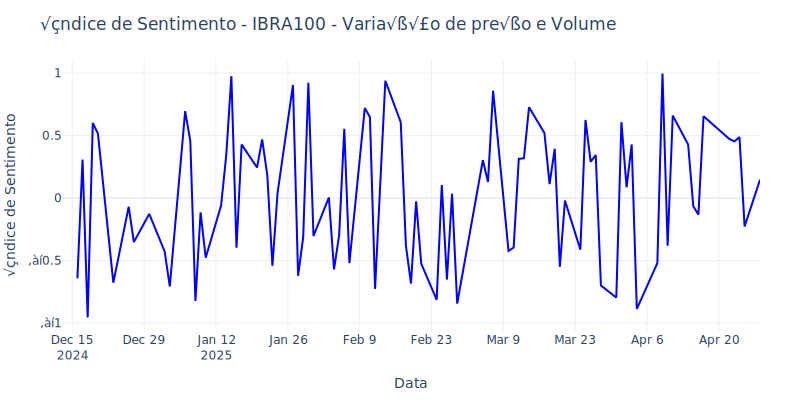

In [6]:
fig = go.Figure()
## ------------------------------
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(df_resultado[['Indice_Sentimento']])
# scaled_df_volume = pd.DataFrame(scaled_features, columns=['Indice_Sentimento'], index=df_resultado.index)
scaled_df_volume = df_resultado.copy()
## ------------------------------

fig.add_trace(go.Scatter(x=scaled_df_volume.index,y=scaled_df_volume['Indice_Sentimento'],mode='lines',
    name=f'√çndice de Sentimento - {carteira}', line=dict(color='blue')))

fig.update_layout(title=f'√çndice de Sentimento - {carteira.upper()} - Varia√ß√£o de pre√ßo e Volume ',width=800,height=400,#legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),xaxis_title='Data',yaxis_title='√çndice de Sentimento',template='plotly_white')

fig.show()

In [7]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import os

# Pasta onde o arquivo ser√° salvo
download_dir = str(os.getcwd()) + r"/data/"

# Configura√ß√µes do Chrome
chrome_options = Options()
chrome_options.add_experimental_option('prefs', {
    "download.default_directory": download_dir,  # muda a pasta de download
    "download.prompt_for_download": False,       # n√£o pede confirma√ß√£o
    "directory_upgrade": True,
    "safebrowsing.enabled": True
})


*√çndice com dados de fluxo (investidor estrangeiro vs local)*
$$
\text{Indice de fluxo} = \frac{\text{Fluxo Lƒ±quido Estrangeiro}}{\text{Volume Total}}
$$ 
Se o √≠ndice estiver muito positivo: otimismo externo (gringos comprando).

Se estiver muito negativo: p√¢nico (gringos vendendo pesado).



In [8]:
driver=webdriver.Chrome(options=chrome_options)
url='https://www.dadosdemercado.com.br/bolsa/investidores-estrangeiros'
driver.get(url)
time.sleep(2)
path='//*[@id="download-csv"]'
botao = driver.find_element(By.XPATH,path)
botao.click()
driver.close()

In [9]:
try:
    os.rename("data/fluxo-estrangeiro (1).csv","data/fluxo-estrangeiro.csv")
except:
    pass

In [10]:
fluxo = pd.read_csv('data/fluxo-estrangeiro.csv')

# Converter a coluna Data para datetime
fluxo['Data'] = pd.to_datetime(fluxo['Data'], format='%d/%m/%Y')

# Fun√ß√£o para limpar e converter os valores para float
def converter_valor(valor):
    if isinstance(valor, str):
        # Remove o sufixo " mi"
        valor = valor.replace(' mi', '')
        # Substitui o ponto de milhar e v√≠rgula decimal para formato float padr√£o
        valor = valor.replace('.', '').replace(',', '.')
        return float(valor)
    return valor

# Aplicar a fun√ß√£o para todas as colunas, exceto 'Data'
colunas_valores = fluxo.columns.difference(['Data'])
for col in colunas_valores:
    fluxo[col] = fluxo[col].apply(converter_valor)


fluxo

Data  Estrangeiro  Institucional  Pessoa f√≠sica  Inst. Financeira  \
0   2025-04-25      1621.62       -1645.63         -30.20            155.54   
1   2025-04-24       882.83        -280.80        -524.64             54.70   
2   2025-04-23      1671.85       -1210.13        -247.50             67.38   
3   2025-04-22      1112.86        -935.41        -127.54            -34.45   
4   2025-04-17      2332.51        -781.91        -273.00          -1326.86   
..         ...          ...            ...            ...               ...   
244 2024-05-07       107.29          46.55           5.27           -140.79   
245 2024-05-06      -128.19         -88.95         194.39             17.70   
246 2024-05-03      1028.27        -522.34        -375.29            -58.40   
247 2024-05-02       603.67        -623.34        -220.19             17.07   
248 2024-04-30     -1398.73         607.61         529.58            251.08   

     Outros  
0   -101.33  
1   -132.10  
2   -281.60  
3    -15.46  
4     49.25  
..      ...  
244  -18.31  
245    5.06  
246  -72.24  
247  222.79  
248   10.47  

[249 rows x 6 columns]

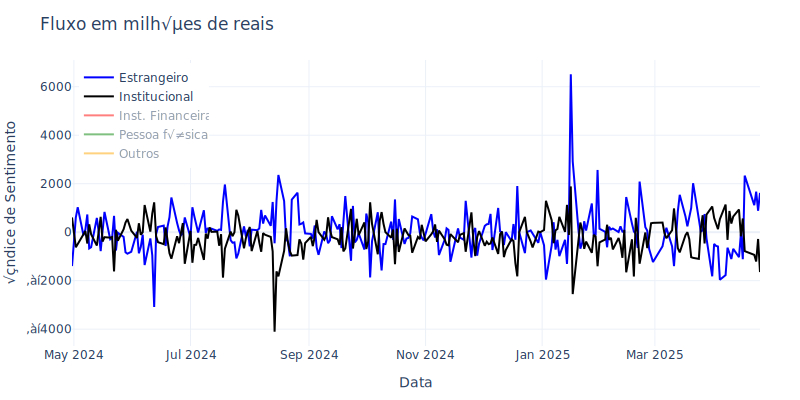

In [11]:
fig = go.Figure()

# Linha principal (o seu √≠ndice de sentimento)
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo.Estrangeiro, mode='lines', name='Estrangeiro', line=dict(color='blue')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo.Institucional, mode='lines', name='Institucional', line=dict(color='black')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Inst. Financeira'], mode='lines', name='Inst. Financeira', line=dict(color='red'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Pessoa f√≠sica'], mode='lines', name='Pessoa f√≠sica', line=dict(color='green'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Outros'], mode='lines', name='Outros', line=dict(color='orange'),
                         visible='legendonly'))
# Layout
fig.update_layout(
    title=f'Fluxo em milh√µes de reais',
    width=800,
    height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='√çndice de Sentimento',
    template='plotly_white'
)

fig.show()

In [12]:

fluxo['Total'] = (fluxo['Estrangeiro']+fluxo['Institucional']+fluxo['Pessoa f√≠sica']+fluxo['Inst. Financeira']+fluxo['Outros'] 	)
fluxo['Total absluto'] = abs(fluxo['Estrangeiro'])+abs(fluxo['Institucional'])+abs(fluxo['Pessoa f√≠sica'])+abs(fluxo['Inst. Financeira'])+abs(fluxo['Outros'] 	)
# fluxo['Total2'] = fluxo[colunas_valores].sum(axis=1) 
fluxo['Indice de fluxo'] = fluxo['Estrangeiro']/fluxo['Total absluto']

ext = fluxo['Estrangeiro']
min_e = ext.min()
max_e = ext.max()
# # √çndice de Sentimento (Estrangeiros) normalizado entre 0 e 1
fluxo['Indice_Estrangeiro'] = (ext - min_e) / (max_e - min_e)

# # Soma dos fluxos estrangeiro e institucional
fluxo_EI = fluxo['Estrangeiro'] + fluxo['Institucional']
min_ei = fluxo_EI.min()
max_ei = fluxo_EI.max()
# √çndice de Sentimento (Estrangeiro + Institucional)
fluxo['Indice_Est_Inst'] = (fluxo_EI - min_ei) / (max_ei - min_ei)

fluxo

Data  Estrangeiro  Institucional  Pessoa f√≠sica  Inst. Financeira  \
0   2025-04-25      1621.62       -1645.63         -30.20            155.54   
1   2025-04-24       882.83        -280.80        -524.64             54.70   
2   2025-04-23      1671.85       -1210.13        -247.50             67.38   
3   2025-04-22      1112.86        -935.41        -127.54            -34.45   
4   2025-04-17      2332.51        -781.91        -273.00          -1326.86   
..         ...          ...            ...            ...               ...   
244 2024-05-07       107.29          46.55           5.27           -140.79   
245 2024-05-06      -128.19         -88.95         194.39             17.70   
246 2024-05-03      1028.27        -522.34        -375.29            -58.40   
247 2024-05-02       603.67        -623.34        -220.19             17.07   
248 2024-04-30     -1398.73         607.61         529.58            251.08   

     Outros         Total  Total absluto  Indice de fluxo  Indice_Estrangeiro  \
0   -101.33 -2.273737e-13        3554.32         0.456239            0.490381   
1   -132.10 -1.000000e-02        1875.07         0.470825            0.413405   
2   -281.60 -2.273737e-13        3478.46         0.480629            0.495615   
3    -15.46 -7.815970e-14        2225.72         0.500000            0.437372   
4     49.25 -1.000000e-02        4763.53         0.489660            0.564450   
..      ...           ...            ...              ...                 ...   
244  -18.31  1.000000e-02         318.21         0.337167            0.332599   
245    5.06  1.000000e-02         434.29        -0.295171            0.308064   
246  -72.24 -7.105427e-14        2056.54         0.500000            0.428558   
247  222.79 -8.526513e-14        1687.06         0.357824            0.384318   
248   10.47  1.000000e-02        2797.47        -0.499998            0.175684   

     Indice_Est_Inst  
0           0.350126  
1           0.398416  
2           0.387593  
3           0.365666  
4           0.471586  
..               ...  
244         0.363844  
245         0.335228  
246         0.391003  
247         0.350460  
248         0.290954  

[249 rows x 11 columns]

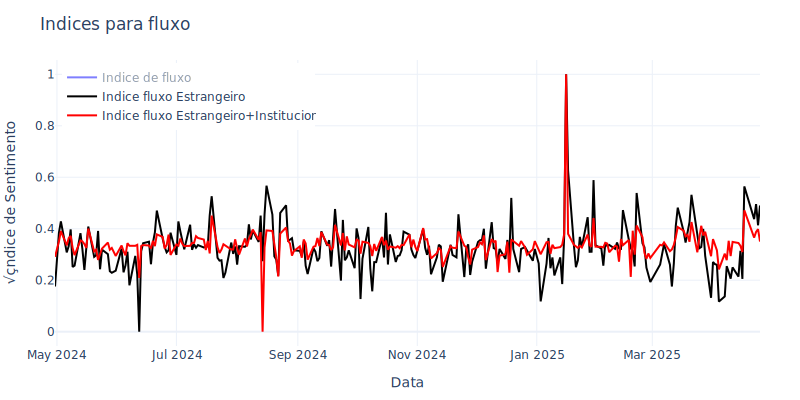

In [13]:
fig = go.Figure()

# Linha principal (o seu √≠ndice de sentimento)
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice de fluxo'], mode='lines', name='Indice de fluxo', line=dict(color='blue'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice_Estrangeiro'], mode='lines', name='Indice fluxo Estrangeiro', line=dict(color='black')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice_Est_Inst'], mode='lines', name='Indice fluxo Estrangeiro+Institucional', line=dict(color='red')))

# Layout
fig.update_layout(
    title=f'Indices para fluxo',
    width=800,
    height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='√çndice de Sentimento',
    template='plotly_white'
)

fig.show()

# VXBR  S&P/B3 Ibovespa VIX

Em termos percentuais, o VIX representa a expectativa anualizada da varia√ß√£o do √≠ndice. Assim, um VIX de 24,83 sugere que o mercado espera uma oscila√ß√£o anualizada de cerca de 24,83% no √≠ndice, o que pode ser interpretado como um cen√°rio de incerteza e poss√≠vel turbul√™ncia nos pr√≥ximos meses.

De forma pr√°tica:

$<$ 20 indicam baixa volatilidade, com investidores mais confiantes e dispostos a correr riscos;

Entre 20 e 30 pontos o mercado est√° em uma faixa de volatilidade m√©dia, sinalizando um risco moderado e maior incerteza;

$>$ 30 pontos, o √≠ndice sinaliza alta volatilidade e maior nervosismo ou medo dos investidores, indicando oscila√ß√µes fortes nos pre√ßos dos ativo

A S&P Dow Jones Indices (S&P DJI) e a B3 lan√ßaram o S&P/B3 Ibovespa VIX, o primeiro √≠ndice de volatilidade impl√≠cita do mercado brasileiro, baseado na metodologia do famoso √≠ndice VIX da Cboe Global Markets. O novo √≠ndice mede a volatilidade impl√≠cita de curto prazo nas op√ß√µes do Ibovespa, oferecendo uma vis√£o de 30 dias sobre a expectativa de volatilidade no Brasil ele serve como refer√™ncia para avaliar o sentimento do mercado e o risco percebido.

In [14]:
driver = webdriver.Chrome(options=chrome_options)
driver.get("https://www.spglobal.com/spdji/pt/indices/indicators/sp-b3-ibovespa-vix/#overview")
time.sleep(2)
botao1 = driver.find_element(By.ID, "onetrust-accept-btn-handler")
botao1.click()
time.sleep(2)
botao2 =  driver.find_element(By.CLASS_NAME, "optanon-allow-all")
botao2.click()
time.sleep(5)
driver.execute_script("window.scrollBy(0, 500);")  # Scroll para o bot√£o aparecer
exportar = driver.find_element(By.XPATH, "//a[contains(text(), 'Exportar')]")
exportar.click()
driver.quit()


In [15]:

# Caminho para o arquivo
arquivo = 'data/PerformanceGraphExport.xls'
# Primeiro, ler o arquivo bruto sem cabe√ßalho
df_raw = pd.read_excel(arquivo, header=None)

# Encontrar a linha onde aparece 'Data efetiva' e 'S&P/B3 Ibovespa VIX'
header_row = None
for i, row in df_raw.iterrows():
    if 'Data efetiva' in row.values and 'S&P/B3 Ibovespa VIX' in row.values:
        header_row = i
        break

if header_row is None:
    raise ValueError("N√£o encontrei a linha de cabe√ßalho com 'Data efetiva' e 'S&P/B3 Ibovespa VIX'!")

# Ler de novo pulando at√© o header_row
vixbr = pd.read_excel(arquivo, skiprows=header_row)

# Selecionar s√≥ as colunas que interessam
vixbr = vixbr[['Data efetiva', 'S&P/B3 Ibovespa VIX']]

# Tentar converter 'Data efetiva' para datetime
vixbr['Data efetiva'] = pd.to_datetime(vixbr['Data efetiva'], errors='coerce')

# Remover linhas que n√£o t√™m data v√°lida
vixbr = vixbr.dropna(subset=['Data efetiva'])

vixbr = vixbr.reset_index(drop=True)
vixbr.columns = ['Data', 'VX']
vixbr[['Data', 'VX']] = vixbr[['Data', 'VX']].apply(pd.to_numeric, errors='coerce')
vixbr['Data'] = pd.to_datetime(vixbr['Data'])
vixbr['VX-diario'] = vixbr['VX'] / (365**(1/2))
vixbr['VX-mes'] = vixbr['VX'] / (12**(1/2))
vixbr=vixbr.set_index('Data')
vixbr

VX  VX-diario    VX-mes
Data                                  
2024-04-25  16.85   0.881969  4.864176
2024-04-26  16.44   0.860509  4.745819
2024-04-29  16.39   0.857892  4.731385
2024-04-30  16.87   0.883016  4.869950
2024-05-02  17.05   0.892438  4.921911
...           ...        ...       ...
2025-04-17  17.94   0.939023  5.178832
2025-04-22  18.40   0.963100  5.311622
2025-04-23  18.16   0.950538  5.242340
2025-04-24  17.93   0.938499  5.175945
2025-04-25  17.38   0.909711  5.017174

[250 rows x 3 columns]

In [16]:
# vix sp500

vix = yf.download('^VIX' , start= vixbr.index[0].date(), end= vixbr.index[-1].date(), interval='1d', auto_adjust=True, threads=True)['Close']
# vix_alinhado = vix.reindex(df.index).ffill() # Garantir que o √≠ndice do VIX √© igual ao do DF e preenche valores faltantes para frente
vix['VIX-diario'] = vix['^VIX'] / (365**(1/2))
vix['VIX-mes']    = vix['^VIX'] / (12**(1/2))
vix

[*********************100%***********************]  1 of 1 completed


Ticker           ^VIX  VIX-diario   VIX-mes
Date                                       
2024-04-25  15.370000    0.804503  4.436937
2024-04-26  15.030000    0.786706  4.338787
2024-04-29  14.670000    0.767863  4.234864
2024-04-30  15.650000    0.819158  4.517766
2024-05-01  15.390000    0.805549  4.442710
...               ...         ...       ...
2025-04-17  29.650000    1.551952  8.559218
2025-04-21  33.820000    1.770220  9.762993
2025-04-22  30.570000    1.600107  8.824799
2025-04-23  28.450001    1.489141  8.212808
2025-04-24  26.469999    1.385503  7.641231

[250 rows x 3 columns]

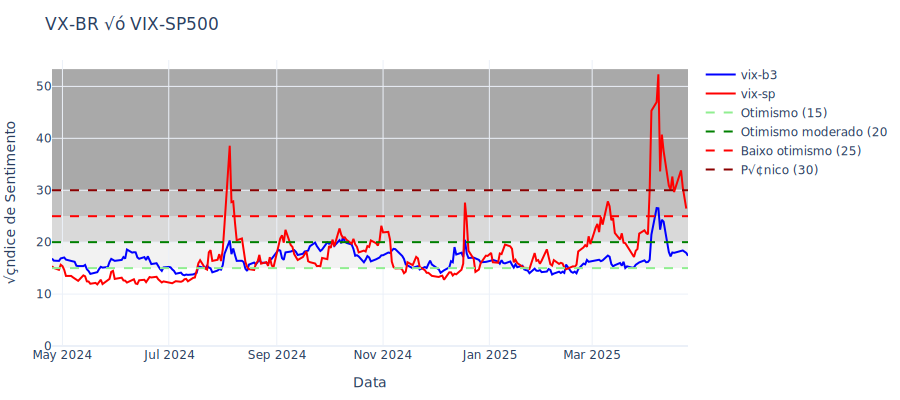

In [17]:
fig = go.Figure()

df=vixbr.copy()

fig.add_trace(go.Scatter( x=df.index, y=df.VX, mode='lines', name=f'vix-b3', line=dict(color='blue')))
fig.add_trace(go.Scatter( x=vix.index , y=vix['^VIX'].values, mode='lines', name=f'vix-sp', line=dict(color='red')))

# Linha de Otimismo (15)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[15, 15], mode='lines', name='Otimismo (15)',
    line=dict(color='lightgreen', dash='dash')))
# Linha de Otimismo moderado (20)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[20, 20], mode='lines', name='Otimismo moderado (20)',
    line=dict(color='green', dash='dash')))
# Linha de Baixo otimismo (25)
fig.add_trace(go.Scatter( x=[df.index.min(), df.index.max()], y=[25, 25], mode='lines', name='Baixo otimismo (25)',
    line=dict(color='red', dash='dash')))
# Linha de P√¢nico (30)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[30, 30],mode='lines',name='P√¢nico (30)',
    line=dict(color='darkred', dash='dash')))

# Faixa < 15 
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=0, y1=15,  fillcolor="white", 
    opacity=0, layer="below",  line_width=0, )
# Faixa 15-20 
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=15, y1=20,  fillcolor="lightgrey", 
    opacity=0.3, layer="below",  line_width=0, )
# Faixa 20-25
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=20, y1=25, fillcolor="grey",  
    opacity=0.3,layer="below", line_width=0,)
# Faixa 25-30
fig.add_shape(type="rect",x0=df.index.min(), x1=df.index.max(),y0=25, y1=30,fillcolor="darkgrey",  
    opacity=0.7,layer="below",line_width=0,)
# Faixa >30 
fig.add_shape(type="rect",x0=df.index.min(), x1=df.index.max(),y0=30, y1=max([vix['^VIX'].max(),df.VX.max()])+1,fillcolor="darkgrey",  
    opacity=1,layer="below",line_width=0,)

# Layout
fig.update_layout(
    title=r'VX-BR √ó VIX-SP500',
    width=900,
    height=400,
    # legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='√çndice de Sentimento',
    template='plotly_white'
)

fig.show()

df=[]


In [18]:
vixes = pd.concat([vixbr['VX-diario'],vix['VIX-diario']],axis=1, join='inner')


In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vix = pd.DataFrame(scaler.fit_transform(vixbr), columns=vixbr.columns, index=vixbr.index)

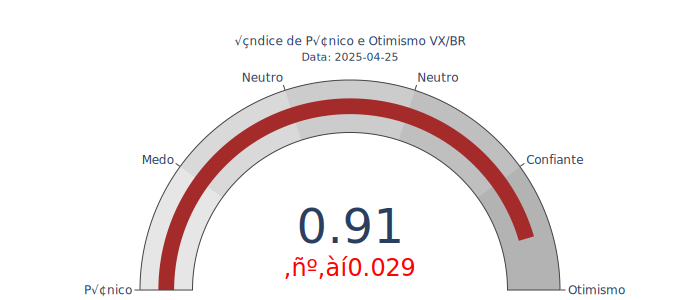

In [20]:
# 5. Gauge
indice_atual = vixbr['VX-diario'].iloc[-1]
indice_ontem = vixbr['VX-diario'].iloc[-2]
variacao = indice_atual - indice_ontem
data_ult = vixbr.index[-1].strftime('%Y-%m-%d')

fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=indice_atual,
    delta={'reference': indice_ontem, 'increasing': {'color': "green"}, 'decreasing': {'color': "red"}},
    number={'font': {'size': 48}},
    gauge={
        'axis': {'range': [0, 1], 'tickvals': [0, 0.2, 0.4, 0.6, 0.8, 1], 
                 'ticktext': ['P√¢nico', 'Medo', 'Neutro', 'Neutro', 'Confiante', 'Otimismo']},
        'bar': {'color': 'brown', 'thickness': 0.3},
        'bgcolor': "lightgray",
        'steps': [
            {'range': [0, 0.2], 'color': '#e6e6e6'},
            {'range': [0.2, 0.4], 'color': '#d9d9d9'},
            {'range': [0.4, 0.6], 'color': '#cccccc'},
            {'range': [0.6, 0.8], 'color': '#bfbfbf'},
            {'range': [0.8, 1.0], 'color': '#b3b3b3'}
        ],
    },
    title={'text': f"√çndice de P√¢nico e Otimismo VX/BR <br><span style='font-size:0.9em'>Data: {data_ult}</span>"}
))

fig.update_layout(height=300, margin={'t': 80, 'b': 10})
fig.show()


**√çndice de P√¢nico nas Bolsas de Valores** O c√°lculo do √≠ndice de p√¢nico nos mercados financeiros est√° intrinsecamente ligado √† medi√ß√£o da volatilidade impl√≠cita, com o VIX (Volatility Index) emergindo como principal refer√™ncia global. Desenvolvido pelo *Chicago Board Options Exchange* (CBOE) em 1993, esse indicador quantifica as expectativas de *oscila√ß√µes no S&P 500 para os pr√≥ximos 30 dias*, servindo como term√¥metro do medo ou euforia dos investidores. No Brasil, a B3 implementou uma vers√£o adaptada, o VXBR, que segue a mesma metodologia aplicada ao Ibovespa. Este relat√≥rio explora os fundamentos matem√°ticos, as varia√ß√µes regionais e as aplica√ß√µes pr√°ticas desses √≠ndices.

**Fundamentos Te√≥ricos da Volatilidade Impl√≠cita** O VIX calcula a volatilidade esperada utilizando pre√ßos de op√ß√µes de compra (call) e venda (put) do S&P 500. Esses derivativos funcionam como contratos de seguro contra movimentos bruscos nos pre√ßos, onde *op√ß√µes de compra refletem apostas em alta* e *op√ß√µes de venda indicam prote√ß√£o contra quedas*. A f√≥rmula do VIX, conforme detalhada pela metodologia do CBOE:
$$
\sigma^2 =  \frac 2T \sum  \frac{\Delta K_i}{K_i^2}\exp(RT)Q(K_i) - \frac 1T\left(\frac F{K_0} - 1\right)^2
$$
onde:
ùúé¬≤ : Vari√¢ncia da volatilidade impl√≠cita;
T: Tempo at√© expira√ß√£o das op√ß√µes;
Ki : Pre√ßos de exerc√≠cio das op√ß√µes;
Q(Ki): Pre√ßo m√©dio das op√ß√µes;
F: Pre√ßo futuro do √≠ndice.

**Metodologia de C√°lculo Pr√°tico**

*Sele√ß√£o de S√©ries Temporais*: Coletar pre√ßos de op√ß√µes do S&P 500 com vencimentos em 23 e 37 dias, garantindo janela m√≥vel de 30 dias

*C√°lculo de Vari√¢ncias*: Para cada expiration date, computar a vari√¢ncia impl√≠cita usando a f√≥rmula de Neuberger (1990), que pondera contribui√ß√µes de diferentes strikes

*Interpola√ß√£o Temporal*: Combinar as vari√¢ncias dos contratos pr√≥ximos (near-term) e seguintes (next-term) para obter volatilidade anualizada:
$$
\text{VIX} = 100 \times \sqrt{ \left( T_1 \sigma_1^2 \frac{N_{T2} - N_{30}}{N_{T2} - N_{T1}} \right) + \left( T_2 \sigma_2^2 \frac{N_{30} - N_{T1}}{N_{T2} - N_{T1}} \right) } \times \frac{365}{30}
$$
onde $N_{T_x}$ representa dias at√© expira√ß√£o.

**Adapta√ß√£o Brasileira: VXBR** (Especificidades do √çndice B3/S&P Ibovespa VIX) Lan√ßado em mar√ßo de 2024, o VXBR replica a metodologia do VIX original por√©m utilizando op√ß√µes do Ibovespa. Durante crises, como a alta de 476% no VIX global em mar√ßo de 2020, o √≠ndice brasileiro demonstra sensibilidade compar√°vel. Seu c√°lculo autom√°tico considera:
1. Liquidez das op√ß√µes do IBOV;
2. Ajustes sazonais no vencimento;
3. Prazos m√≠nimos de 30 dias para evitar distor√ß√µes.

**Desafios na Implementa√ß√£o Local**
Diferentemente do mercado americano, *a baixa liquidez de derivativos no Brasil* exige filtros adicionais para excluir strikes sem negocia√ß√£o, potencialmente introduzindo vi√©s amostral. A B3 realiza rodadas de ajuste metodol√≥gico peri√≥dicas para mitigar esses efeitos. 

**Alternativas Computacionais: √çndice Medo vs. Gan√¢ncia** -
*Abordagem Multifatorial* - 
O Fear & Greed Index, popularizado pela CNN, combina sete vari√°veis ponderadas:

vix * 0.05 + putCallRatio * 0.1 + marketBreadth * 0.15 + junkBonds * 0.2 +  safeHavenDemand * 0.25 + treasuryYield * 0.15 +  peRatio * 0.1

Nesse modelo, cada fator captura diferentes dimens√µes de risco:
1. Demanda por t√≠tulos do Tesouro (25%): Ref√∫gios seguros indicam medo;
2. Bonds de alto risco (20%): Aceita√ß√£o de risco corporativo sinaliza gan√¢ncia;
3. Raz√£o Put/Call (10%): Mais puts sugerem hedging contra quedas.

**Limita√ß√µes Metodol√≥gicas**
Enquanto o VIX deriva diretamente de dados de mercado, √≠ndices compostos como o Fear & Greed dependem de escolhas subjetivas na pondera√ß√£o de fatores. Estudos apontam correla√ß√£o de apenas 0.65 entre ambas as m√©tricas em per√≠odos de estresse.

**Aplica√ß√µes Pr√°ticas para Investidores**

*Estrat√©gias de Hedge*
Fundos institucionais utilizam o VIX para calibrar prote√ß√µes:
1. Quando o VIX supera 30, gestores aumentam exposi√ß√£o em op√ß√µes de venda;
2. Abaixo de 15, reduzem custos de hedge priorizando calls.

*Sinal Contr√°rio (Contrarian Indicator)*
Extremos hist√≥ricos do VIX (>40 ou <15) marcaram pontos de revers√£o de mercado em 82% dos casos desde 1990. Por exemplo: Pico de 89.53 em outubro de 2008 (crise Lehman Brothers); M√≠nimo de 9.51 em novembro de 2017 (expans√£o monet√°ria p√≥s-crise).

**Perspectivas Futuras e Inova√ß√µes**

*Modelos Machine Learning*
Pesquisas recentes testam redes neurais LSTM para prever o VIX usando:
1. Dados de sentimento em redes sociais;
2. Fluxos de ordens em dark pools;
3. Indicadores macroecon√¥micos em tempo real.

Resultados preliminares mostram redu√ß√£o de 20% no erro quadr√°tico m√©dio versus modelos ARIMA tradicionais.

**VIX Setoriais**
Derivativos segmentados por setores (tecnologia, energia) est√£o em desenvolvimento, permitindo hedge espec√≠fico. O CBOE Sector VIX para tech j√° representa 12% do mercado de volatilidade6.

**Conclus√£o e Recomenda√ß√µes**
O c√°lculo do √≠ndice de p√¢nico envolve tanto complexidade matem√°tica quanto compreens√£o comportamental. Para investidores brasileiros, monitorar o VXBR oferece insights valiosos, por√©m √© crucial:

Validar contra dados locais de liquidez;

Combinar com indicadores globais para evitar miopias regionais;

Utilizar simula√ß√µes de Monte Carlo para testar estrat√©gias de hedge.

Institutos de pesquisa sugerem a integra√ß√£o de modelos h√≠bridos, combinando VIX tradicional com dados alternativos (geopol√≠tica, clima) para antecipar crises sist√™micas. A evolu√ß√£o cont√≠nua desses √≠ndices refor√ßa seu papel como b√∫ssolas em oceanos de incerteza financeira

# testes

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


dados = data
resultado = pd.DataFrame()
for acao in tickers:
    df = dados[acao].copy()
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=7).std()
    df['High-Low Range'] = (df['High'] - df['Low']) / df['Low']
    df = df[['Return', 'Volatility', 'High-Low Range']]
    df.columns = [f'{acao}_Return', f'{acao}_Volatility', f'{acao}_HLRange']
    
    if resultado.empty:
        resultado = df
    else:
        resultado = resultado.join(df)

resultado = resultado.dropna()

# Indicador de n√∫mero de a√ß√µes subindo/caindo
# 1 para subida, -1 para queda
up_down = resultado[[col for col in resultado.columns if 'Return' in col]].apply(lambda x: np.where(x > 0, 1, -1))
resultado['Acoes_Subindo'] = up_down.sum(axis=1) / len(tickers)

# Agora normalizar tudo
features = [col for col in resultado.columns if ('Return' in col or 'Volatility' in col or 'HLRange' in col)] + ['Acoes_Subindo']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(resultado[features])

scaled = pd.DataFrame(scaled_features, columns=features, index=resultado.index)

# C√°lculo final do √çndice de P√¢nico/Otimismo
scaled['Panic Optimism Index'] = scaled.mean(axis=1)

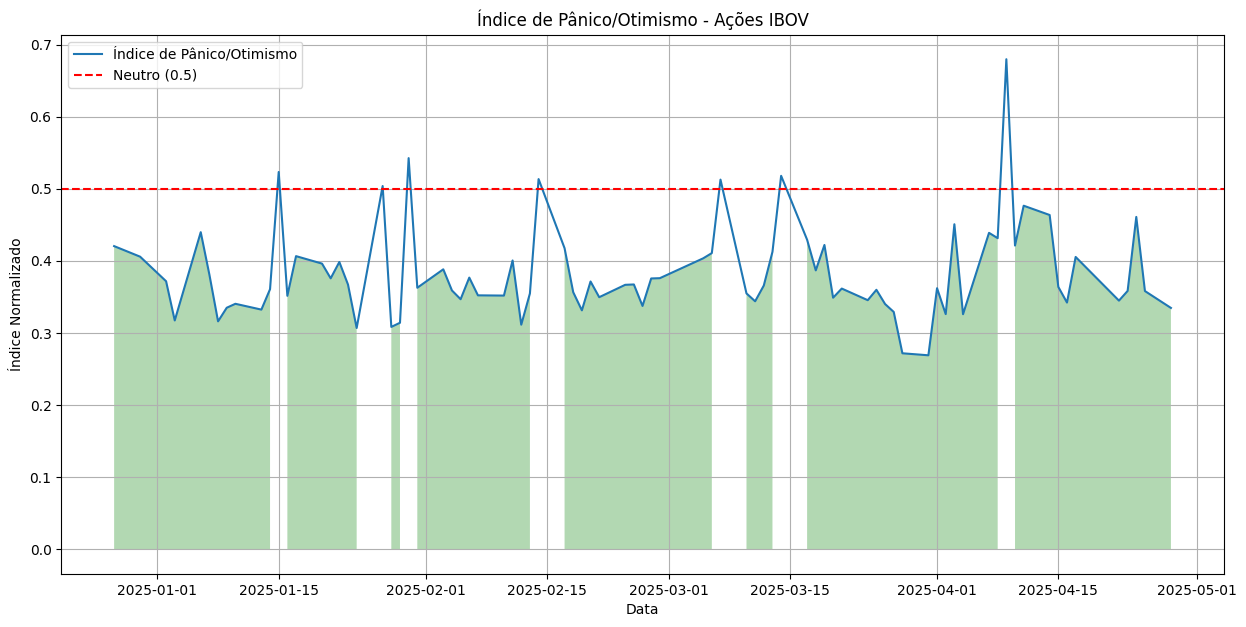

In [22]:
plt.figure(figsize=(15,7))
plt.plot(scaled.index, scaled['Panic Optimism Index'], label='√çndice de P√¢nico/Otimismo')
plt.axhline(0.5, color='red', linestyle='--', label='Neutro (0.5)')
plt.fill_between(scaled.index, 0, scaled['Panic Optimism Index'], where=scaled['Panic Optimism Index']>=0.5, facecolor='red', alpha=0.3)
plt.fill_between(scaled.index, 0, scaled['Panic Optimism Index'], where=scaled['Panic Optimism Index']<0.5, facecolor='green', alpha=0.3)
plt.title('√çndice de P√¢nico/Otimismo - A√ß√µes IBOV')
plt.xlabel('Data')
plt.ylabel('√çndice Normalizado')
plt.legend()
plt.grid(True)
plt.show()

## tesouro direto

Tesouro -- https://www.tesourotransparente.gov.br/ckan/dataset/vendas-do-tesouro-direto



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'data/VendasTesouroDireto.csv'
df = pd.read_csv(file_path,sep=';', decimal=',', skiprows=0)

df.head()

Tipo Titulo Vencimento do Titulo  Data Venda  \
0  Tesouro IGPM+ com Juros Semestrais           01/07/2005  17/06/2002   
1                       Tesouro Selic           16/02/2005  18/06/2002   
2                       Tesouro Selic           18/01/2006  18/06/2002   
3  Tesouro IGPM+ com Juros Semestrais           01/04/2008  02/09/2002   
4  Tesouro IGPM+ com Juros Semestrais           01/01/2031  02/09/2002   

            PU  Quantidade      Valor  
0  1099.100000         0.2     219.82  
1  1302.210097        82.2  107041.66  
2  1276.380000         8.0   10211.04  
3  1067.290000         8.0    8538.32  
4  1436.950000         2.0    2873.90

In [24]:
df['Vencimento do Titulo'] = pd.to_datetime(df['Vencimento do Titulo'], dayfirst=True) 
df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True) 

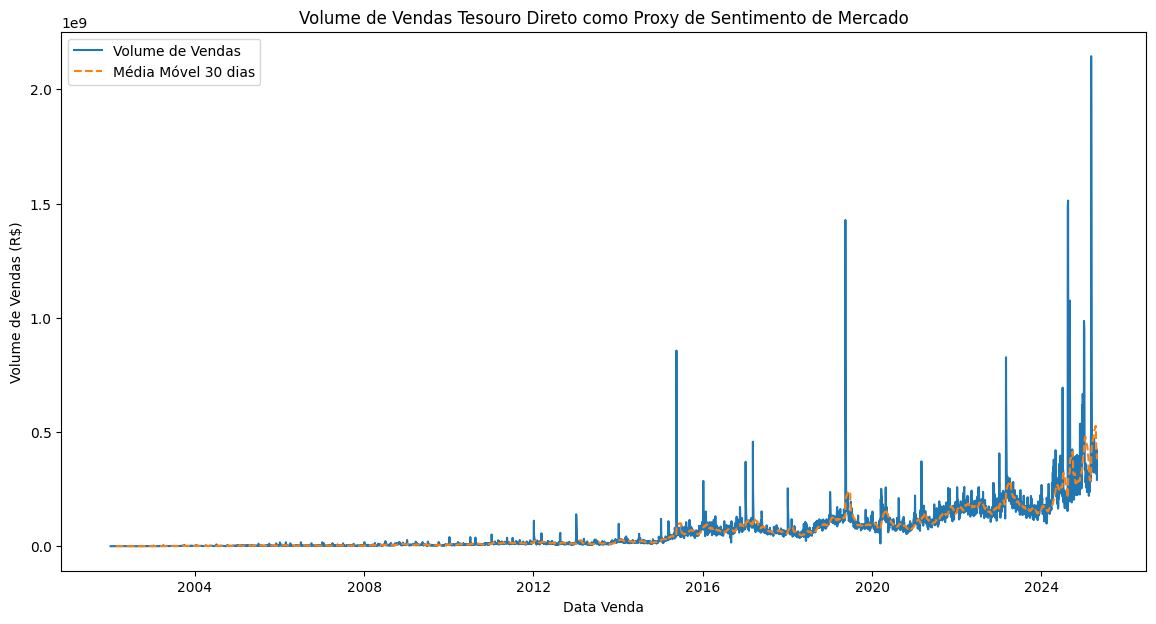

In [25]:
'''
Se o volume de compra for muito alto ‚Üí Indicativo de medo.
Se for baixo ‚Üí Indicativo de otimismo.

(Opcional) Normalizar o volume para remover efeitos sazonais ou tend√™ncias de longo prazo.

Plotar um gr√°fico (ex: matplotlib/seaborn) para visualizar isso.
'''

teste1 = df.copy()
# Agrupar por dia o volume de vendas
vendas_diarias = teste1.groupby('Data Venda')['Valor'].sum().reset_index()
# Criar uma m√©trica de sentimento
# normalizar usando a m√©dia m√≥vel de 30 dias
vendas_diarias['MediaMovel30'] = vendas_diarias['Valor'].rolling(window=30).mean()

# Definir Sentimento: medo se vendas > m√©dia m√≥vel, otimismo se < m√©dia m√≥vel
vendas_diarias['Sentimento'] = vendas_diarias['Valor'] > vendas_diarias['MediaMovel30']
vendas_diarias['Sentimento'] = vendas_diarias['Sentimento'].map({True: 'Medo', False: 'Otimismo'})

# Visualizar
plt.figure(figsize=(14,7))
sns.lineplot(data=vendas_diarias, x='Data Venda', y='Valor', label='Volume de Vendas')
sns.lineplot(data=vendas_diarias, x='Data Venda', y='MediaMovel30', label='M√©dia M√≥vel 30 dias', linestyle='--')
plt.title('Volume de Vendas Tesouro Direto como Proxy de Sentimento de Mercado')
plt.xlabel('Data Venda')
plt.ylabel('Volume de Vendas (R$)')
plt.legend()
plt.show()

In [26]:
df.columns

Index(['Tipo Titulo', 'Vencimento do Titulo', 'Data Venda', 'PU', 'Quantidade',
       'Valor'],
      dtype='object')

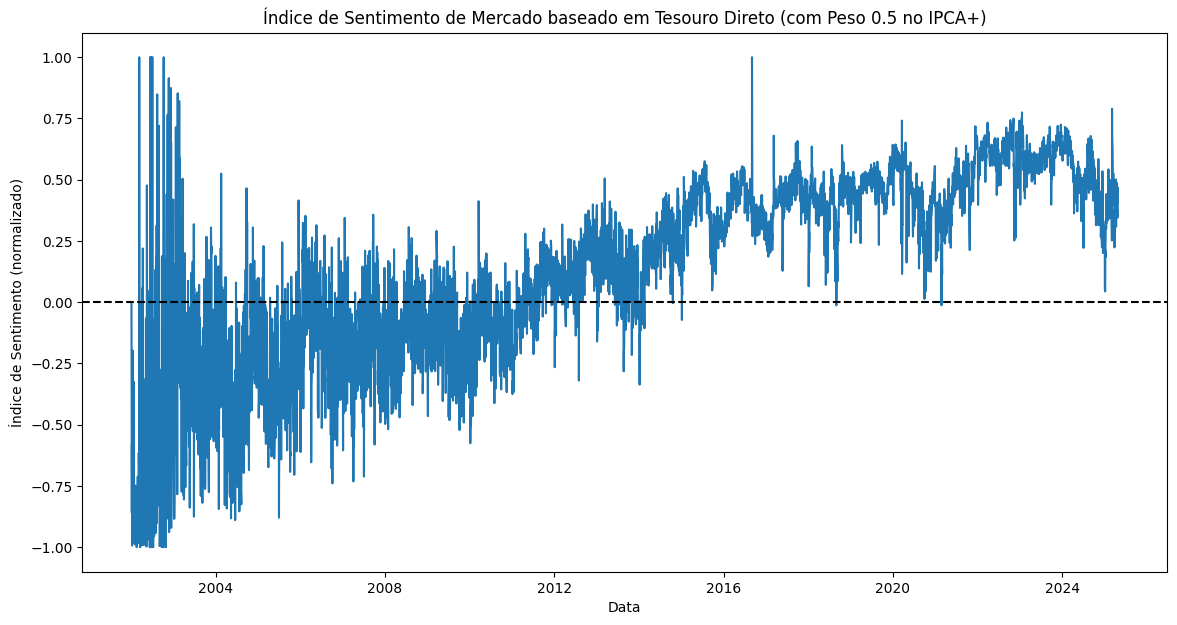

In [27]:
''''
Agrupar o volume di√°rio para cada tipo
Criar uma "pontua√ß√£o" de sentimento para cada tipo:
Tesouro Selic ‚Üí Peso +1 para medo.
Tesouro IPCA+ ‚Üí Peso 0.5 medo moderado.
Tesouro Prefixado ‚Üí Peso -1 para otimismo.
Calcular um √≠ndice de sentimento di√°rio combinando essas pontua√ß√µes.
'''
teste2=df.copy()
#  Categorizar tipos de t√≠tulo para sentimento
def classificar_sentimento(titulo):
    titulo = titulo.lower()
    if 'selic' in titulo:
        return 'Seguro'  # Medo forte
    elif 'ipca' in titulo:
        return 'Intermediario'  # Medo moderado
    elif 'prefixado' in titulo or 'pre' in titulo or 'educa' in titulo or 'renda+' in titulo:
        return 'Arriscado'  # Otimismo
    else:
        return 'Outro'

teste2['Categoria'] = teste2['Tipo Titulo'].apply(classificar_sentimento)

# Agregar volume por dia e categoria
vendas_categorias = teste2.groupby(['Data Venda', 'Categoria'])['Valor'].sum().unstack(fill_value=0)

#  Definir novos pesos de sentimento
pesos = {
    'Seguro': +1,
    'Intermediario': +0.5,
    'Arriscado': -1,
    'Outro': 0
}

#  Calcular o √≠ndice de sentimento
vendas_categorias['Indice_Sentimento'] = (
    vendas_categorias['Seguro'] * pesos['Seguro'] +
    vendas_categorias['Intermediario'] * pesos['Intermediario'] +
    vendas_categorias['Arriscado'] * pesos['Arriscado']
)

#  normalizar pelo volume total di√°rio
vendas_categorias['Indice_Sentimento_Normalizado'] = vendas_categorias['Indice_Sentimento'] / (
    vendas_categorias[['Seguro', 'Intermediario', 'Arriscado']].sum(axis=1) + 1e-9
)

plt.figure(figsize=(14,7))
sns.lineplot(data=vendas_categorias, x=vendas_categorias.index, y='Indice_Sentimento_Normalizado')
plt.axhline(0, color='black', linestyle='--')
plt.title('√çndice de Sentimento de Mercado baseado em Tesouro Direto (com Peso 0.5 no IPCA+)')
plt.xlabel('Data')
plt.ylabel('√çndice de Sentimento (normalizado)')
plt.show()


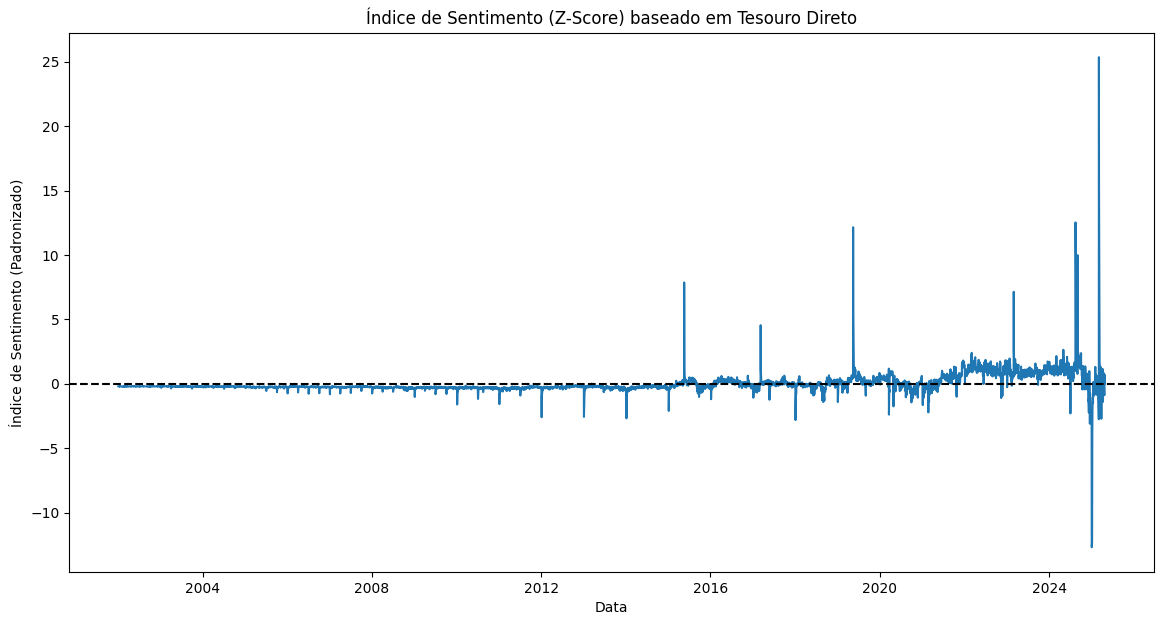

In [28]:
'''
Calcular volume di√°rio por categoria (Seguro, Intermediario, Arriscado).
Calcular z-score: Calcular z-score de volume para cada categoria 
Aplicar pesos: (Selic) ‚Üí +1 (IPCA+) ‚Üí +0.5 (Prefixado, Educa+) ‚Üí -1
Somar tudo para construir um √≠ndice cont√≠nuo de sentimento padronizado.
'''
from scipy.stats import zscore

# # Carregar e tratar os dados
# df = pd.read_csv('/mnt/data/VendasTesouroDireto.csv', sep=';', encoding='latin1')
# df.columns = df.columns.str.replace('"', '').str.strip()
# df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True)
# # Categorizar tipos de t√≠tulo
# def classificar_sentimento(titulo):
#     titulo = titulo.lower()
#     if 'selic' in titulo:
#         return 'Seguro'
#     elif 'ipca' in titulo:
#         return 'Intermediario'
#     elif 'prefixado' in titulo or 'pre' in titulo or 'educa' in titulo or 'renda+' in titulo:
#         return 'Arriscado'
#     else:
#         return 'Outro'
# df['Categoria'] = df['Tipo Titulo'].apply(classificar_sentimento)
# # Agregar volume por dia e categoria
# vendas_categorias = df.groupby(['Data Venda', 'Categoria'])['Valor'].sum().unstack(fill_value=0)

# Calcular z-score para cada categoria
vendas_categorias_z = vendas_categorias.copy()
for categoria in ['Seguro', 'Intermediario', 'Arriscado']:
    if categoria in vendas_categorias.columns:
        vendas_categorias_z[categoria] = zscore(vendas_categorias[categoria].fillna(0))

# #  Aplicar pesos
# pesos = {
#     'Seguro': +1,
#     'Intermediario': +0.5,
#     'Arriscado': -1,
#     'Outro': 0  # N√£o estamos usando "Outro"
# }

vendas_categorias_z['Indice_Sentimento_ZScore'] = (
    vendas_categorias_z['Seguro'] * pesos['Seguro'] +
    vendas_categorias_z['Intermediario'] * pesos['Intermediario'] +
    vendas_categorias_z['Arriscado'] * pesos['Arriscado']
)

# Visualizar
plt.figure(figsize=(14,7))
sns.lineplot(data=vendas_categorias_z, x=vendas_categorias_z.index, y='Indice_Sentimento_ZScore')
plt.axhline(0, color='black', linestyle='--')
plt.title('√çndice de Sentimento (Z-Score) baseado em Tesouro Direto')
plt.xlabel('Data')
plt.ylabel('√çndice de Sentimento (Padronizado)')
plt.show()

In [29]:
ibovespa = yf.download('^BVSP', start = teste1['Data Venda'].min() , end= teste1['Data Venda'].max())[['Close']]
ibovespa = ibovespa.reset_index(drop=False)
ibovespa.columns = ['Date', 'Close']  # for√ßa os nomes corretos
ibovespa.head(2)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Date    Close
0 2002-01-04  14332.0
1 2002-01-07  14379.0

Correla√ß√£o entre Sentimento (z-score) e Retorno do IBOV: 0.1204
                            OLS Regression Results                            
Dep. Variable:                Retorno   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 29 Apr 2025   Prob (F-statistic):                nan
Time:                        06:22:45   Log-Likelihood:                    nan
No. Observations:                5733   AIC:                               nan
Df Residuals:                    5731   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

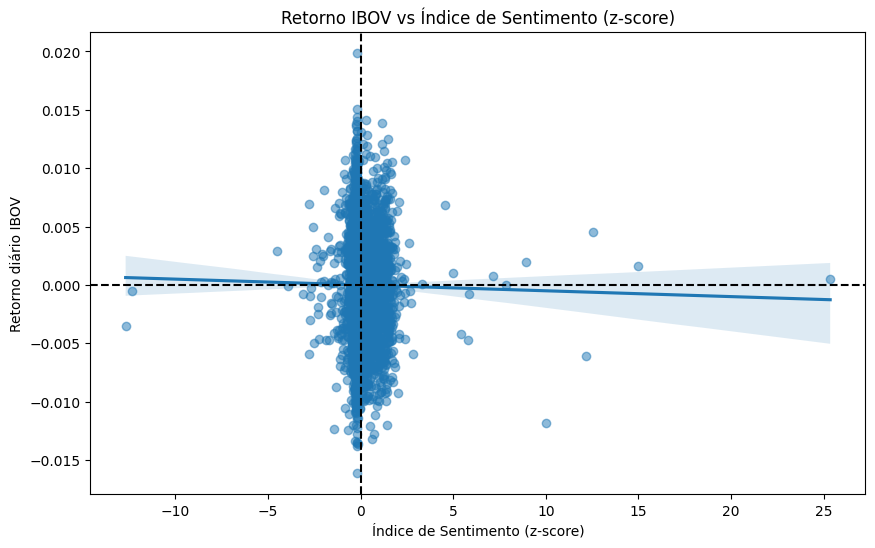

In [30]:
from scipy.stats import linregress
import statsmodels.api as sm

# √çndice de Sentimento (calculado antes)
# Vamos assumir que 'vendas_categorias_z' j√° foi criado, com a coluna 'Indice_Sentimento_ZScore'

# Aqui, vamos fazer uma dummy para exemplificar
# Remover abaixo quando tiver dados reais

np.random.seed(42)
ibov = pd.DataFrame(index=vendas_categorias_z.index)
ibovespa['Close'] = 100000 + np.cumsum(np.random.normal(0, 500, size=len(ibovespa)))

# Calcular retorno di√°rio do IBOVESPA
ibovespa['Retorno'] = ibovespa['Close'].pct_change()

# Juntar as bases
# sentimento_ibov = vendas_categorias_z[['Indice_Sentimento_ZScore']].join(ibovespa[['Retorno']]).dropna()
# df_preco_reset = ibovespa[['Retorno']].reset_index()  
df_sentimento_reset = vendas_categorias_z[['Indice_Sentimento_ZScore']].reset_index()
# Agora fazer o merge
sentimento_ibov = pd.merge(
    ibovespa,#df_preco_reset,
    df_sentimento_reset,
    left_on='Date', 
    right_on='Data Venda',  
    how='inner')
#  An√°lise de Correla√ß√£o
correlacao = sentimento_ibov.corr().iloc[0,1]
print(f"Correla√ß√£o entre Sentimento (z-score) e Retorno do IBOV: {correlacao:.4f}")

# Regress√£o Linear
X = sentimento_ibov['Indice_Sentimento_ZScore']
y = sentimento_ibov['Retorno']
X = sm.add_constant(X)  # adiciona intercepto
modelo = sm.OLS(y, X).fit()
print(modelo.summary())
#  Gr√°fico de dispers√£o
plt.figure(figsize=(10,6))
sns.regplot(x='Indice_Sentimento_ZScore', y='Retorno', data=sentimento_ibov, scatter_kws={'alpha':0.5})
plt.title('Retorno IBOV vs √çndice de Sentimento (z-score)')
plt.xlabel('√çndice de Sentimento (z-score)')
plt.ylabel('Retorno di√°rio IBOV')
plt.axhline(0, linestyle='--', color='black')
plt.axvline(0, linestyle='--', color='black')
plt.show()

In [31]:
#  An√°lise com defasagem (sentimento de ontem vs retorno de hoje)
sentimento_ibov['Sentimento_Lag1'] = sentimento_ibov['Indice_Sentimento_ZScore'].shift(1)
sentimento_ibov.dropna(inplace=True)
lagged_model = sm.OLS(sentimento_ibov['Retorno'], sm.add_constant(sentimento_ibov['Sentimento_Lag1'])).fit()
print(lagged_model.summary())


                            OLS Regression Results                            
Dep. Variable:                Retorno   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.266
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.260
Time:                        06:22:46   Log-Likelihood:                 23399.
No. Observations:                5732   AIC:                        -4.679e+04
Df Residuals:                    5730   BIC:                        -4.678e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.252e-06   5.39e-05     


Estat√≠sticas dos retornos por quantil de sentimento:
                        mean       std  count    Sharpe
Quantil_Sentimento                                     
1                  -0.000060  0.003799   1147 -0.015756
2                   0.000184  0.003918   1146  0.046947
3                   0.000073  0.004516   1146  0.016140
4                  -0.000096  0.003856   1146 -0.024827
5                  -0.000108  0.004278   1147 -0.025194


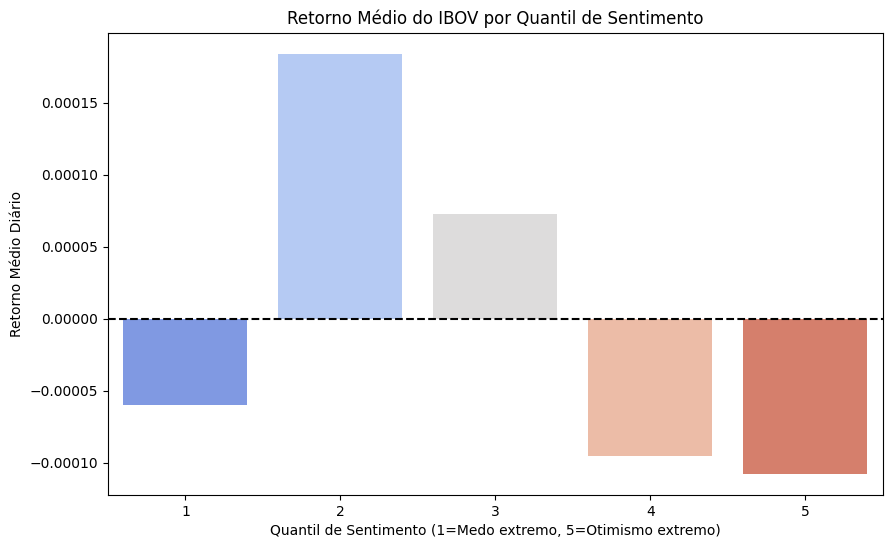


Percentual de dias positivos por quantil:
Quantil_Sentimento
1    0.480384
2    0.513089
3    0.512216
4    0.501745
5    0.492589
Name: Retorno, dtype: float64


In [32]:
''' 
An√°lise de Quantis:
Quantil 1 (pior sentimento, medo extremo): ‚Üí Retorno m√©dio do IBOV.
Quantil 5 (melhor sentimento, otimismo extremo): ‚Üí Retorno m√©dio do IBOV.
Sharpe Ratio em cada quantil: ‚Üí Risco/retorno ajustado.
% de dias positivos: ‚Üí Em que quantil o mercado sobe mais vezes.

Quantil	Sentimento	        Esperado para o IBOV
1	    Medo extremo	    Retornos positivos (contrarian) ou negativos (p√¢nico)
5	    Otimismo extremo	Retornos negativos (euforia?) ou positivos (confian√ßa)
Se quando o sentimento est√° muito ruim (Quantil 1), o IBOV performa melhor, isso mostra um comportamento contrarian: ‚Üí Comprar quando todos est√£o com medo.
Se for o contr√°rio, confirma momentum.
'''
# Dividir o sentimento em quantis
sentimento_ibov['Quantil_Sentimento'] = pd.qcut(sentimento_ibov['Indice_Sentimento_ZScore'], 5, labels=[1,2,3,4,5])

# Calcular estat√≠sticas dos retornos em cada quantil
estatisticas_quantis = sentimento_ibov.groupby('Quantil_Sentimento', observed=True)['Retorno'].agg(['mean', 'std', 'count'])
estatisticas_quantis['Sharpe'] = estatisticas_quantis['mean'] / estatisticas_quantis['std']

print("\nEstat√≠sticas dos retornos por quantil de sentimento:")
print(estatisticas_quantis)

#  Gr√°fico de retornos m√©dios por quantil
plt.figure(figsize=(10,6))
# sns.barplot(x=estatisticas_quantis.index, y='mean', data=estatisticas_quantis, palette="coolwarm")
sns.barplot(x=estatisticas_quantis.index, y='mean', hue=estatisticas_quantis.index, data=estatisticas_quantis, palette="coolwarm", legend=False)
plt.title('Retorno M√©dio do IBOV por Quantil de Sentimento')
plt.xlabel('Quantil de Sentimento (1=Medo extremo, 5=Otimismo extremo)')
plt.ylabel('Retorno M√©dio Di√°rio')
plt.axhline(0, linestyle='--', color='black')
plt.show()

# Interpreta√ß√£o adicional: 
# Posso calcular tamb√©m quantos dias deram retorno positivo/negativo em cada quantil
pos_neg = sentimento_ibov.groupby('Quantil_Sentimento', observed=True)['Retorno'].apply(lambda x: (x > 0).mean())
print("\nPercentual de dias positivos por quantil:")
print(pos_neg)


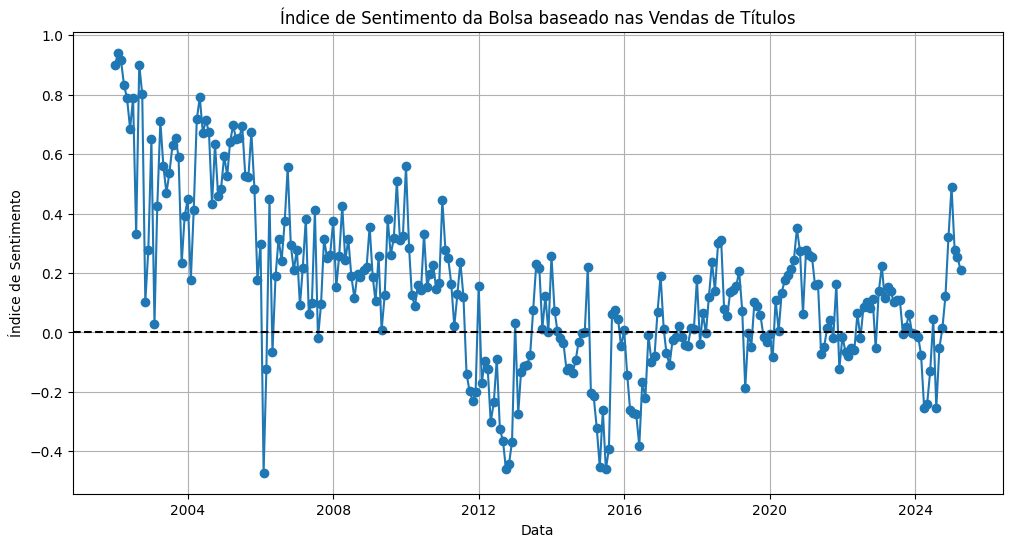

In [33]:
'''
Indice= Venda Otimismo - Venda Medo / Venda Otimismo + Venda Medo
Indice= Venda Otimismo + Venda Medo / Venda Otimismo - Venda Medo
  
Se s√≥ venderem prefixado (otimismo), ele d√° +1.
Se s√≥ venderem IPCA/Selic (medo), ele d√° -1.
Se venderem igual, ele d√° 0.
'''

df.columns = df.columns.str.strip()
# Converter datas
df['Data Venda'] = pd.to_datetime(df['Data Venda'], errors='coerce', dayfirst=True)
#  Filtrar apenas os t√≠tulos principais
titulos_otimismo = ['Tesouro Prefixado']
titulos_medo = ['Tesouro Selic', 'Tesouro IPCA+']

# . Separar vendas por tipo
df['Otimismo'] = df['Tipo Titulo'].apply(lambda x: 1 if any(t in x for t in titulos_otimismo) else 0)
df['Medo'] = df['Tipo Titulo'].apply(lambda x: 1 if any(t in x for t in titulos_medo) else 0)

# grupar os valores
grupo = df.groupby(df['Data Venda'].dt.to_period('M')).apply(
    lambda x: pd.Series({
        'Venda_Otimismo': x.loc[x['Otimismo']==1, 'Quantidade'].sum(),
        'Venda_Medo': x.loc[x['Medo']==1, 'Quantidade'].sum()}))



grupo = grupo.reset_index()

# Criar o √≠ndice de sentimento
# F√≥rmula: (Venda_Otimismo - Venda_Medo) / (Venda_Otimismo + Venda_Medo)
grupo['Indice_Sentimento'] = (grupo['Venda_Otimismo'] - grupo['Venda_Medo']) / (grupo['Venda_Otimismo'] + grupo['Venda_Medo'])

# 9. Plotar
plt.figure(figsize=(12,6))
plt.plot(grupo['Data Venda'].dt.to_timestamp(), grupo['Indice_Sentimento'], marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.title('√çndice de Sentimento da Bolsa baseado nas Vendas de T√≠tulos')
plt.xlabel('Data')
plt.ylabel('√çndice de Sentimento')
plt.grid(True)
plt.show()

In [34]:
import pandas as pd

# 1. Carregar o dataframe
df = pd.read_csv('data/VendasTesouroDireto.csv',sep=';',decimal=',')

# 2. Ajustar datas
df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True, errors='coerce')

# 3. Filtrar os tipos relevantes
def identificar_tipo(titulo):
    if 'Prefixado' in titulo:
        return 'LTN'
    elif 'IPCA+' in titulo:
        return 'NTN-B'
    elif 'Selic' in titulo:
        return 'LFT'
    else:
        return 'OUTROS'

df['Tipo Simplificado'] = df['Tipo Titulo'].apply(identificar_tipo)

# 4. Agrupar por data e tipo
pivot = df.pivot_table(index='Data Venda', 
                       columns='Tipo Simplificado', 
                       values='Valor', 
                       aggfunc='sum').fillna(0)

# 5. Calcular o volume total
pivot['Total'] = pivot.sum(axis=1)

# 6. Aplicar a f√≥rmula
pivot['Indice Sentimento'] = (pivot.get('LTN', 0) - (pivot.get('NTN-B', 0) + pivot.get('LFT', 0))) / pivot['Total']

# 7. Mostrar o resultado
print(pivot[['Indice Sentimento']])


Tipo Simplificado  Indice Sentimento
Data Venda                          
2002-01-04                  0.000000
2002-01-07                  0.792742
2002-01-08                  0.509715
2002-01-09                  0.768280
2002-01-10                  0.854691
...                              ...
2025-04-17                 -0.643233
2025-04-22                 -0.611740
2025-04-23                 -0.675325
2025-04-24                 -0.710016
2025-04-25                 -0.677032

[5761 rows x 1 columns]


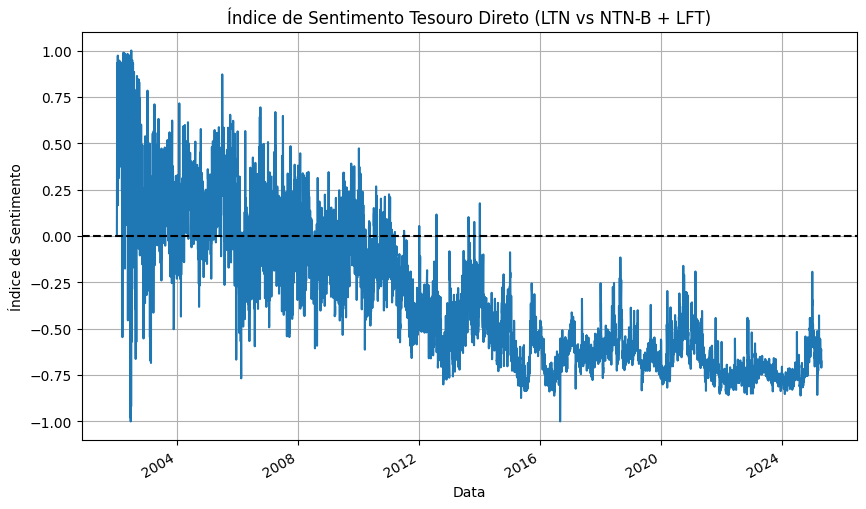

In [35]:
import matplotlib.pyplot as plt

pivot['Indice Sentimento'].plot(figsize=(10,6), title='√çndice de Sentimento Tesouro Direto (LTN vs NTN-B + LFT)')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('√çndice de Sentimento')
plt.xlabel('Data')
plt.grid(True)
plt.show()
